Device: cuda
Model has 535,818 parameters
Epoch 1/100 | Loss: 1.6648, Train Acc: 81.56% | Cluster Acc: 0.9282, ARI: 0.8513, NMI: 0.8388 | Entropy: 0.0768, Conf: 0.9719, Margin: 0.9482
Epoch 2/100 | Loss: 1.5297, Train Acc: 93.56% | Cluster Acc: 0.9536, ARI: 0.9009, NMI: 0.8858 | Entropy: 0.0475, Conf: 0.9821, Margin: 0.9668
Epoch 3/100 | Loss: 1.5103, Train Acc: 95.42% | Cluster Acc: 0.9574, ARI: 0.9087, NMI: 0.8934 | Entropy: 0.0386, Conf: 0.9849, Margin: 0.9716
Epoch 4/100 | Loss: 1.5008, Train Acc: 96.26% | Cluster Acc: 0.9653, ARI: 0.9249, NMI: 0.9114 | Entropy: 0.0306, Conf: 0.9883, Margin: 0.9780
Epoch 5/100 | Loss: 1.4944, Train Acc: 96.86% | Cluster Acc: 0.9686, ARI: 0.9320, NMI: 0.9169 | Entropy: 0.0246, Conf: 0.9907, Margin: 0.9825
Epoch 6/100 | Loss: 1.4910, Train Acc: 97.17% | Cluster Acc: 0.9721, ARI: 0.9395, NMI: 0.9253 | Entropy: 0.0236, Conf: 0.9906, Margin: 0.9822
Epoch 7/100 | Loss: 1.4872, Train Acc: 97.53% | Cluster Acc: 0.9748, ARI: 0.9453, NMI: 0.9311 | Entropy: 0

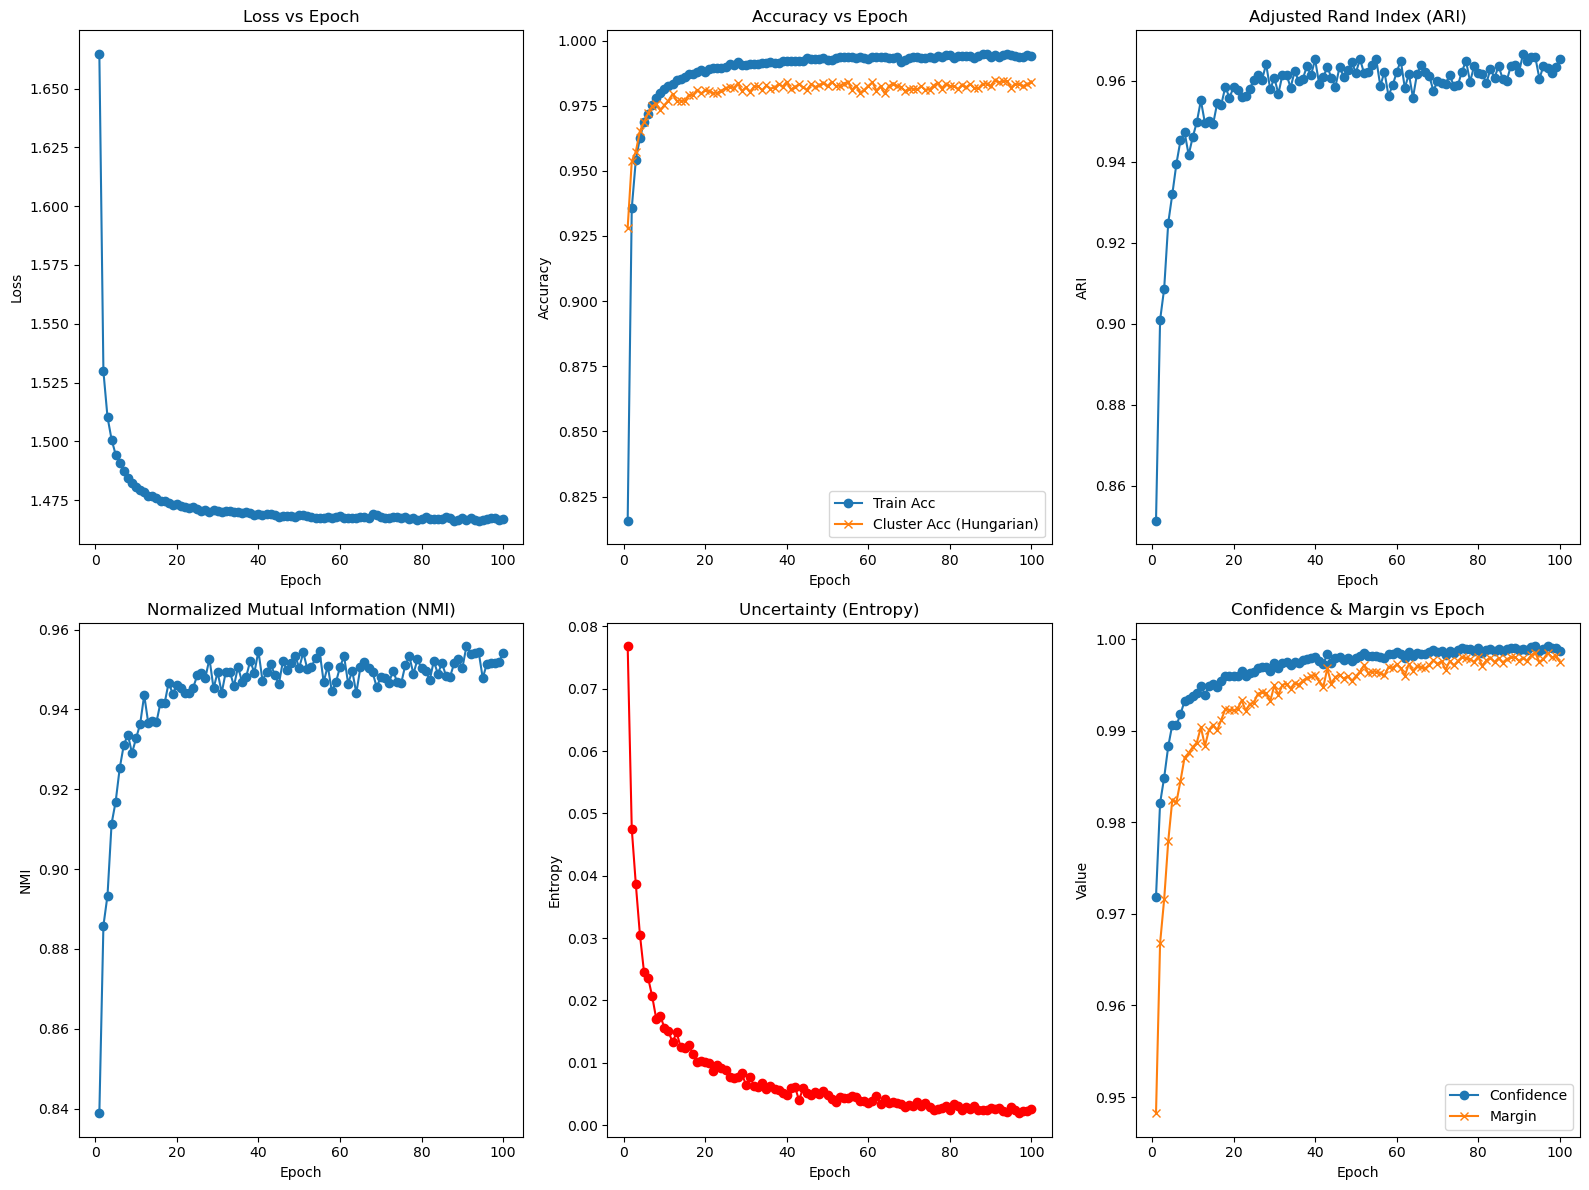

In [9]:
# =========================================================
# MNIST_Clustering_Model_with_Uncertainty.py
# =========================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

# =========================================================
# Utilities
# =========================================================
def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

# =========================================================
# Data
# =========================================================
def get_mnist_loaders(batch_size=256, data_dir="./data"):
    transform = transforms.Compose([transforms.ToTensor()])
    train = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
    test  = datasets.MNIST(data_dir, train=False, download=True, transform=transform)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# =========================================================
# Simple Clustering Model
# =========================================================
class MNISTClusteringModel(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512, n_clusters=10):
        super().__init__()
        self.n_clusters = n_clusters
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.cluster_layer = nn.Linear(hidden_dim // 2, n_clusters)
        
    def forward(self, x):
        features = self.encoder(x)
        cluster_scores = self.cluster_layer(features)
        cluster_probs = F.softmax(cluster_scores, dim=1)
        return cluster_probs, features

# =========================================================
# Clustering Metrics
# =========================================================
def hungarian_mapping(y_true, y_pred):
    n_clusters = max(y_pred.max(), y_true.max()) + 1
    cost_matrix = np.zeros((n_clusters, n_clusters), dtype=np.int64)
    
    for i in range(len(y_pred)):
        cost_matrix[y_pred[i], y_true[i]] += 1
    
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    mapping = dict(zip(row_ind, col_ind))
    
    mapped_pred = np.array([mapping.get(x, -1) for x in y_pred])
    accuracy = (mapped_pred == y_true).mean()
    
    return accuracy, mapped_pred, mapping

# =========================================================
# Uncertainty Computation
# =========================================================
def compute_uncertainty(cluster_probs):
    """Compute entropy, confidence, margin from softmax probs"""
    entropy = -torch.sum(cluster_probs * torch.log(cluster_probs + 1e-8), dim=1)
    confidence = torch.max(cluster_probs, dim=1)[0]
    top2 = torch.topk(cluster_probs, 2, dim=1).values
    margin = top2[:, 0] - top2[:, 1]
    return entropy.cpu().numpy(), confidence.cpu().numpy(), margin.cpu().numpy()

def evaluate_clustering_with_uncertainty(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    all_entropy, all_conf, all_margin = [], [], []
    
    with torch.no_grad():
        for data, target in data_loader:
            data = data.view(data.size(0), -1).to(device)
            cluster_probs, _ = model(data)
            
            preds = cluster_probs.argmax(dim=1).cpu().numpy()
            entropy, confidence, margin = compute_uncertainty(cluster_probs)
            
            all_preds.extend(preds)
            all_labels.extend(target.numpy())
            all_entropy.extend(entropy)
            all_conf.extend(confidence)
            all_margin.extend(margin)
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    acc, mapped_pred, mapping = hungarian_mapping(all_labels, all_preds)
    ari = adjusted_rand_score(all_labels, all_preds)
    nmi = normalized_mutual_info_score(all_labels, all_preds)
    
    return acc, ari, nmi, np.mean(all_entropy), np.mean(all_conf), np.mean(all_margin)

# =========================================================
# Training
# =========================================================
def train_clustering_model(model, train_loader, test_loader, device, epochs=10, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    model.to(device)
    
    history = {"loss": [], "train_acc": [], "cluster_acc": [], "ari": [], "nmi": [],
               "entropy": [], "confidence": [], "margin": []}
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for data, target in train_loader:
            data = data.view(data.size(0), -1).to(device)
            target = target.to(device)
            
            optimizer.zero_grad()
            cluster_probs, _ = model(data)
            loss = criterion(cluster_probs, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pred = cluster_probs.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        
        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        
        cluster_acc, ari, nmi, entropy, confidence, margin = evaluate_clustering_with_uncertainty(
            model, test_loader, device
        )
        
        history["loss"].append(avg_loss)
        history["train_acc"].append(train_acc)
        history["cluster_acc"].append(cluster_acc)
        history["ari"].append(ari)
        history["nmi"].append(nmi)
        history["entropy"].append(entropy)
        history["confidence"].append(confidence)
        history["margin"].append(margin)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Loss: {avg_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
              f"Cluster Acc: {cluster_acc:.4f}, ARI: {ari:.4f}, NMI: {nmi:.4f} | "
              f"Entropy: {entropy:.4f}, Conf: {confidence:.4f}, Margin: {margin:.4f}")
    
    return history

# =========================================================
# Plotting
# =========================================================
def plot_history(history):
    epochs = range(1, len(history["loss"]) + 1)
    
    plt.figure(figsize=(16, 12))
    
    # Loss
    plt.subplot(2,3,1)
    plt.plot(epochs, history["loss"], marker='o')
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    # Accuracy
    plt.subplot(2,3,2)
    plt.plot(epochs, history["train_acc"], marker='o', label="Train Acc")
    plt.plot(epochs, history["cluster_acc"], marker='x', label="Cluster Acc (Hungarian)")
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # ARI
    plt.subplot(2,3,3)
    plt.plot(epochs, history["ari"], marker='o')
    plt.title("Adjusted Rand Index (ARI)")
    plt.xlabel("Epoch")
    plt.ylabel("ARI")
    
    # NMI
    plt.subplot(2,3,4)
    plt.plot(epochs, history["nmi"], marker='o')
    plt.title("Normalized Mutual Information (NMI)")
    plt.xlabel("Epoch")
    plt.ylabel("NMI")
    
    # Entropy
    plt.subplot(2,3,5)
    plt.plot(epochs, history["entropy"], marker='o', color='red')
    plt.title("Uncertainty (Entropy)")
    plt.xlabel("Epoch")
    plt.ylabel("Entropy")
    
    # Confidence & Margin
    plt.subplot(2,3,6)
    plt.plot(epochs, history["confidence"], marker='o', label="Confidence")
    plt.plot(epochs, history["margin"], marker='x', label="Margin")
    plt.title("Confidence & Margin vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# =========================================================
# Main
# =========================================================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)
    
    set_seed(42)
    train_loader, test_loader = get_mnist_loaders(batch_size=256)
    
    model = MNISTClusteringModel(n_clusters=10)
    print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
    
    history = train_clustering_model(model, train_loader, test_loader, device, epochs=100, lr=1e-3)
    
    plot_history(history)
